In [1]:
import numpy as np
from spectral_clustering import spectral_clustering
import functions_for_plotting
from asymmetric_laplacian_distribution import get_index_per_class, get_labels, labels_to_layout_mapping
from sklearn.cluster import KMeans
import training_set_split
import seaborn as sns
import prediction_strength
import importlib
import matplotlib.pyplot as plt
from prediction_strength import get_F1_score_per_k
from matplotlib.legend import Legend
import scipy

In [131]:
#eigval_total = np.load("CrossValidation/clear/eigenvalues/eigval_clear_equal_noise=[0,0.2]_Euclidean_k=10_reg=None.npy")
#eigval_total = np.load("Noise_Analysis/Eigenvalues/Ambiguous_Noise=[0,0.2]/eigval_ambig_equal_noise=[0,0.2]_Euclidean_k=10_reg=None_weighting=False.npy")
eigval_total = np.load("eigval_day20_Euclidean_k=10_reg=0.01_100clusters.npy")

In [219]:
#eigval_valid = np.load("CrossValidation/ambig/eigenvalues/eigval_ambig_equal_noise=[0,0.2]_Euclidean_k=10_reg=None_2_fold_3unbalanced_valid.npy")
#eigval_train = np.load("CrossValidation/ambig/eigenvalues/eigval_ambig_equal_noise=[0,0.2]_Euclidean_k=10_reg=None_2_fold_3unbalanced_train.npy")

In [99]:
# https://books.google.de/books?id=CmRjDwAAQBAJ&pg=PA235&lpg=PA235&dq=calculate+eigenvalue+gap&source=bl&ots=miWsy6Gxak&sig=ACfU3U0UNTsxXGWJcozhvyeUrSdx5mU02g&hl=de&sa=X&ved=2ahUKEwj_jZ-GufLpAhUIhlwKHVnXDD8Q6AEwCXoECAkQAQ#v=onepage&q=calculate%20eigenvalue%20gap&f=false
def get_num_clusters(eigval):
    gaps = np.diff(eigval)
    t = np.mean(np.abs(gaps - np.mean(gaps))) * 1.482
    #print(t)
    ind = np.where(gaps >= t)[0][0]
    #print(ind)
    k = len(gaps) - ind + 1
    return k

In [100]:
def spec_alt(eigvals, alpha = 0.05, maxk=None):
    threshold = 1-alpha
    N = len(eigvals)
    if maxk is None:
        maxk = N
    for k in range(2,maxk):
        q = N - k
        nu = (k-1) * (k+2) / 2
        #mean_first_k_eigvals = np.mean(eigvals[:k])
        #approx = q * mean_first_k_eigvals**2 / (1-mean_first_k_eigvals)**2
        #fact = -(N-1-q-(k**2 +1)/3*k + approx)
        #summed_q_eigval = np.sum(eigvals[:q])
        #ln_Vq = np.log(np.prod(k*eigvals[:q]/summed_q_eigval))
        #tstat = fact * ln_Vq
        
        fact =  N-1 - q - (2*k**2 + 2)/ (6 * k) + q * (np.mean(eigvals[1:q])**2) / ((1-np.mean(eigvals[1:q]))**2)
        Vk = np.prod((k-1)*eigvals[1:q] / np.sum(eigvals[1:q]))
        tstat = -fact*np.log(Vk)
     
        test = scipy.stats.chi2.ppf(tstat, nu)
        
        if test > threshold:
            print(test,k)
            return k
        

In [132]:
eigval = eigval_total

In [133]:
eig_differences = np.diff(eigval)
print(eig_differences)

[0.0007842  0.0007331  0.00054758 ... 0.02564887 0.00699572 0.04668125]


In [134]:
print(np.mean(eig_differences))

0.0001107991070608046


In [135]:
mean_eig_difference = np.mean(eig_differences)
k_mean = (np.where(eig_differences>mean_eig_difference)[0]+1)[0]
if k_mean == 1:
    print("No trivial solution!!!")
    k_mean = (np.where(eig_differences>mean_eig_difference)[0]+1)[1]
print(mean_eig_difference)
print(k_mean)

No trivial solution!!!
0.0001107991070608046
2


In [136]:
threshold = mean_eig_difference+1*np.std(eig_differences)
k_std = (np.where(eig_differences >threshold)[0] + 1)[0]
if k_std == 1:
    print("No trivial solution!!!")
    k_std = (np.where(eig_differences>threshold)[0]+1)[1]
print(k_std)

No trivial solution!!!
2


In [137]:
k_max = np.argmax(eig_differences) + 1
if k_max == 1:
    print("No trivial solution!!!")
    k_max = np.argmax(eig_differences[1])+1+1
print(k_max)

13905


In [138]:
k_mean_100 = (np.where(eig_differences > np.mean(eig_differences[0:100]))[0] +1)[0]
if k_mean_100 == 1:
    print("No trivial solution!!!")
    k_mean_100 = (np.where(eig_differences>np.mean(eig_differences[0:100]))[0]+1)[1]
print(k_mean_100)

4


In [139]:
k_std_100 = (np.where(eig_differences > (np.mean(eig_differences[0:100])+1*np.std(eig_differences[0:100])))[0] + 1)[0]
if k_std_100 == 1:
    print("No trivial solution!!!")
    k_std_100 = (np.where(eig_differences > (np.mean(eig_differences[0:100])+1*np.std(eig_differences[0:100])))[0]+1)[1]
print(k_std_100)

6


In [140]:
save_file = "eigenvalues_day20_Euclidean_k=10_reg=0.01_first_100.pdf"

In [141]:
title = "Eigenvalues of Graph Laplacian of Day20 \n reg = 0.01"

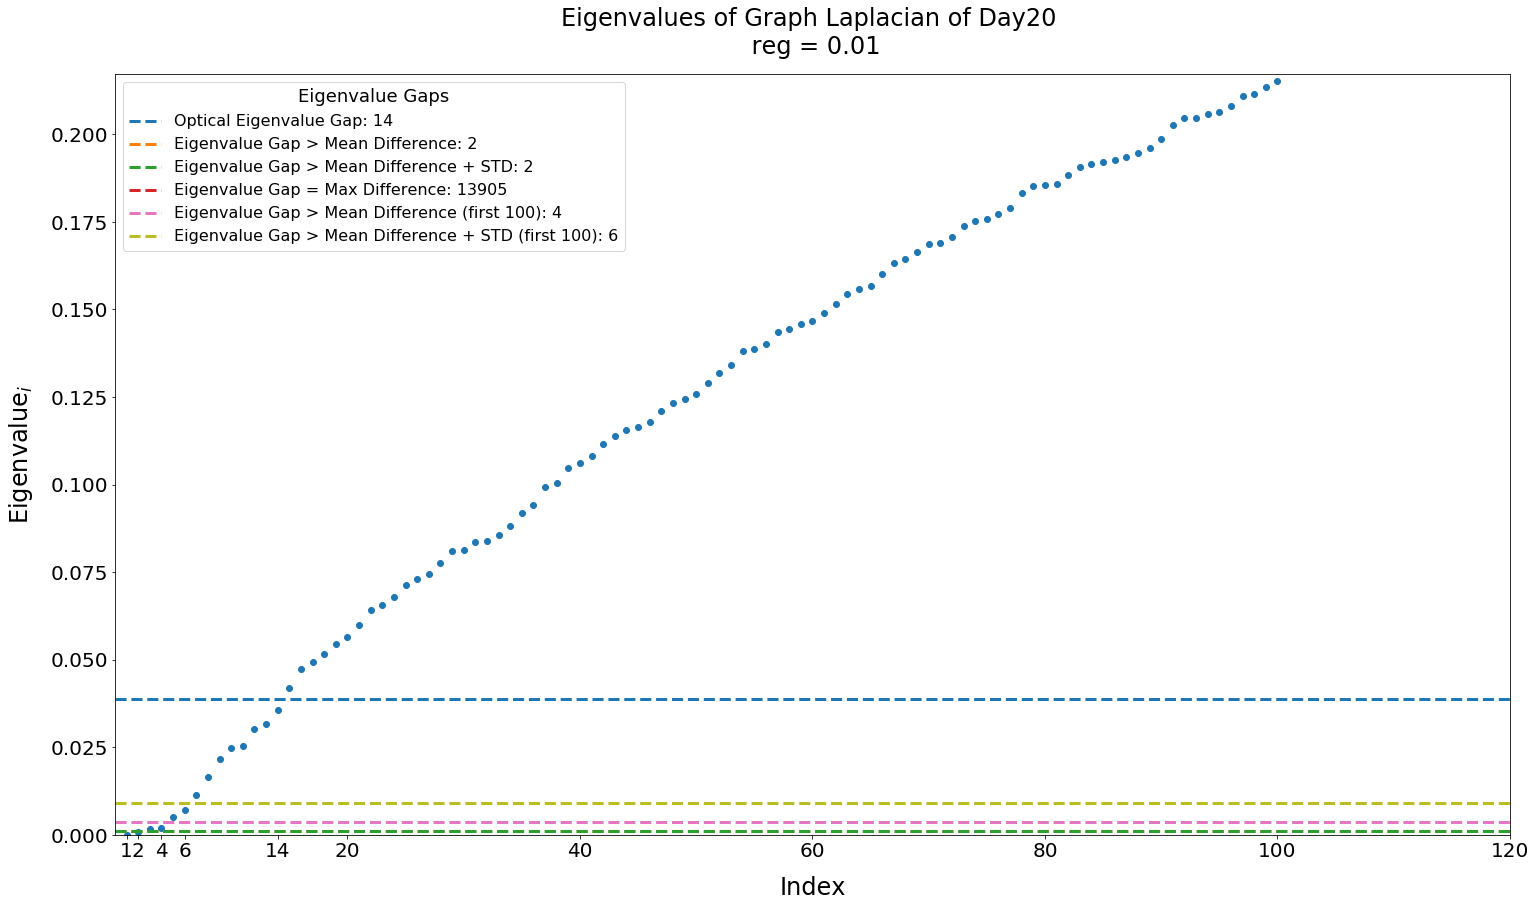

In [143]:
fig, ax = plt.subplots(figsize=(25,14))
eigenvalue_range = [0,100]
k_clusters = 14
n_clusters = None

if eigenvalue_range:
    ax.scatter(range(eigenvalue_range[0]+1,eigenvalue_range[1]+1), eigval[eigenvalue_range[0]:eigenvalue_range[1]])
    ax.set_xlim(eigenvalue_range[0],eigenvalue_range[1]+1)
    ax.set_ylim(eigval[eigenvalue_range[0]], eigval[eigenvalue_range[1]+1])
    if n_clusters:
        x_gaps = np.unique([n_clusters,k_clusters,k_mean,k_std,k_max,k_mean_100,k_std_100])
        x_gaps = x_gaps[x_gaps<eigenvalue_range[1]+1]
    else:
        x_gaps = np.unique([k_clusters,k_mean,k_std,k_max,k_mean_100,k_std_100])
        x_gaps = x_gaps[x_gaps<eigenvalue_range[1]+1]
    
else:
    ax.scatter(range(len(eigval)), eigval)
    x_gaps = np.unique([k_clusters,k_mean,k_std,k_max,k_mean_100,k_std_100])
    
    
if n_clusters:    
    ax.axhline(eigval[n_clusters - 1] + (eigval[n_clusters] - eigval[n_clusters - 1]) / 2, c="C0", linestyle="-",
                label="True N Clusters Eigenvalue Gap: " + str(n_clusters),  linewidth=3)
    ax.axhline(eigval[k_clusters - 1] + (eigval[k_clusters] - eigval[k_clusters - 1]) / 2, c="C0", linestyle="--",
                    label="True Clear Clusters Eigenvalue Gap: " + str(k_clusters),  linewidth=3)

else:
    ax.axhline(eigval[k_clusters - 1] + (eigval[k_clusters] - eigval[k_clusters - 1]) / 2, c="C0", linestyle="--",
                    label="Optical Eigenvalue Gap: " + str(k_clusters),  linewidth=3)


ax.axhline(eigval[k_mean - 1] + (eigval[k_mean] - eigval[k_mean - 1]) / 2, c="C1", linestyle="--",
                label="Eigenvalue Gap > Mean Difference: " + str(k_mean),linewidth=3)
  
ax.axhline(eigval[k_std - 1] + (eigval[k_std] - eigval[k_std - 1]) / 2, c="C2", linestyle="--",
                label="Eigenvalue Gap > Mean Difference + STD: " + str(k_std),linewidth=3)

ax.axhline(eigval[k_max - 1] + (eigval[k_max] - eigval[k_max - 1]) / 2, c="C3", linestyle="--",
                label="Eigenvalue Gap = Max Difference: " + str(k_max),linewidth=3)

ax.axhline(eigval[k_mean_100 - 1] + (eigval[k_mean_100] - eigval[k_mean_100 - 1]) / 2, c="C6", linestyle="--",
                label="Eigenvalue Gap > Mean Difference (first 100): " + str(k_mean_100),linewidth=3)

ax.axhline(eigval[k_std_100 - 1] + (eigval[k_std_100] - eigval[k_std_100 - 1]) / 2, c="C8", linestyle="--",
                label="Eigenvalue Gap > Mean Difference + STD (first 100): " + str(k_std_100),linewidth=3)



x_ticks = plt.xticks([1] + list(plt.xticks()[0][1:]) + list(x_gaps))

ax.set_xlabel("Index", fontsize=24, labelpad=15)
ax.set_ylabel("Eigenvalue$_i$", fontsize=24,labelpad=15)
ax.set_title(title, fontsize=24, pad=20)
leg = ax.legend(fontsize=16, loc ="upper left", title = "Eigenvalue Gaps")
plt.setp(leg.get_title(),fontsize='18')
ax.tick_params(axis='both', labelsize=20)
#plt.savefig(save_file)
#plt.close()